<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/bro.png" width="150px"></div>

# Bro IDS Network Data to Scikit-Learn
In this notebook we're going to be using the BroThon Python module and explore the functionality that enables us to easily go from Bro IDS data to Pandas to Scikit-Learn. Once we get our data in a form that is usable by Scikit-Learn we have a wide array of data analysis and machine learning algorithms at our disposal.

<div style="float: right; margin: 0px 0px 0px 0px"><img src="images/pandas.png" width="300px"></div>

### Software
- BroThon: https://github.com/Kitware/BroThon
- Pandas: https://github.com/pandas-dev/pandas
- Scikit-Learn: http://scikit-learn.org/stable/index.html

### Techniques
<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/scikit.png" width="220px"></div>

- One Hot Encoding: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
- PCA: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- Kmeans: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

### Thanks
- DummyEncoder class, used internally as part of DataFrameToMatrix(), is based on a great talk from Tom Augspurger's at PyData Chicago 2016: https://youtu.be/KLPtEBokqQ0

### Code Availability
All this code in this notebook is from the examples/bro_to_scikit.py file in the BroThon repository (https://github.com/Kitware/BroThon). If you have any questions/problems please don't hesitate to open up an Issue in GitHub or even better submit a PR. :) 

<div style="float: left; margin: 20px 20px 20px 20px"><img src="https://www.kitware.com/img/small_logo_over.png"></div>

In [38]:
# Third Party Imports
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Local imports
import brothon
from brothon import bro_log_reader
from brothon.analysis import dataframe_to_matrix

# Good to print out versions of stuff
print('BroThon: {:s}'.format(brothon.__version__))
print('Pandas: {:s}'.format(pd.__version__))
print('Numpy: {:s}'.format(np.__version__))
print('Scikit Learn Version:', sklearn.__version__)

BroThon: 0.2.1
Pandas: 0.19.2
Numpy: 1.12.1
Scikit Learn Version: 0.18.1


## Quickly go from Bro IDS log to Pandas DataFrame

In [39]:
# Load in the Bro IDS dns logs
reader = bro_log_reader.BroLogReader('../data/dns.log')

# Create a Pandas dataframe from reader
bro_df = pd.DataFrame(reader.readrows())

# Print out the head of the dataframe
bro_df.head()

Successfully monitoring ../data/dns.log...


,AA,RA,RD,TC,TTLs,Z,answers,id.orig_h,id.orig_p,id.resp_h,...,qclass_name,qtype,qtype_name,query,rcode,rcode_name,rejected,trans_id,ts,uid
0,False,True,True,False,36.000000,0,54.245.228.191,192.168.33.10,1030,4.2.2.3,...,C_INTERNET,1,A,guyspy.com,0,NOERROR,False,44949,2013-09-15 17:44:27.631940,CZGShC2znK1sV7jdI7
1,False,True,True,False,"1000.000000,36.000000",0,"guyspy.com,54.245.228.191",192.168.33.10,1030,4.2.2.3,...,C_INTERNET,1,A,www.guyspy.com,0,NOERROR,False,50071,2013-09-15 17:44:27.696869,CZGShC2znK1sV7jdI7
2,False,True,True,False,"60.000000,60.000000,60.000000,60.000000,60.000...",0,"54.230.86.87,54.230.86.18,54.230.87.160,54.230...",192.168.33.10,1030,4.2.2.3,...,C_INTERNET,1,A,devrubn8mli40.cloudfront.net,0,NOERROR,False,39062,2013-09-15 17:44:28.060639,CZGShC2znK1sV7jdI7
3,False,True,True,False,"60.000000,60.000000,60.000000,60.000000,60.000...",0,"54.230.86.87,54.230.86.18,54.230.84.20,54.230....",192.168.33.10,1030,4.2.2.3,...,C_INTERNET,1,A,d31qbv1cthcecs.cloudfront.net,0,NOERROR,False,7312,2013-09-15 17:44:28.141795,CZGShC2znK1sV7jdI7
4,False,True,True,False,"4993.000000,129.000000,129.000000,129.000000",0,"cdn.entrust.net.c.footprint.net,192.221.123.25...",192.168.33.10,1030,4.2.2.3,...,C_INTERNET,1,A,crl.entrust.net,0,NOERROR,False,41872,2013-09-15 17:44:28.422704,CZGShC2znK1sV7jdI7


<div style="float: left; margin: 20px -10px 0px -40px"><img src="images/confused.jpg" width="200px"></div>
<div style="float: right; margin: 20px -10px 0px -10px"><img src="images/pandas.png" width="300px"></div>
## So... what just happened?
**Yep it was quick... the two little lines of code above turned a Bro IDS log (any log) into a Pandas DataFrame. The BroThon package also supports streaming data from dynamic/active logs, handles log rotations and in general tries to make your life a bit easier when doing data analysis and machine learning on Bro data.**

**Now that we have the data in a dataframe there are a million wonderful things we could do for data munging, processing and analysis but that will have to wait for another time/notebook.**

In [40]:
# Using Pandas we can easily and efficiently compute additional data metrics
# Here we use the vectorized operations of Pandas/Numpy to compute query length
bro_df['query_length'] = bro_df['query'].str.len()

## DNS records are a mix of numeric and categorical data
When we look at the dns records some of the data is numerical and some of it is categorical so we'll need a way of handling both data types in a generalized way. BroThon has a DataFrameToMatrix class that handles a lot of the details and mechanics of combining numerical and categorical data, we'll use below.

In [41]:
# These are the features we want (note some of these are categorical :)
features = ['AA', 'RA', 'RD', 'TC', 'Z', 'rejected', 'proto', 'query', 
            'qclass_name', 'qtype_name', 'rcode_name', 'query_length']
feature_df = bro_df[features]
feature_df.head()

,AA,RA,RD,TC,Z,rejected,proto,query,qclass_name,qtype_name,rcode_name,query_length
0,False,True,True,False,0,False,udp,guyspy.com,C_INTERNET,A,NOERROR,10
1,False,True,True,False,0,False,udp,www.guyspy.com,C_INTERNET,A,NOERROR,14
2,False,True,True,False,0,False,udp,devrubn8mli40.cloudfront.net,C_INTERNET,A,NOERROR,28
3,False,True,True,False,0,False,udp,d31qbv1cthcecs.cloudfront.net,C_INTERNET,A,NOERROR,29
4,False,True,True,False,0,False,udp,crl.entrust.net,C_INTERNET,A,NOERROR,15


<div style="float: right; margin: -10px 40px -10px 40px"><img src="images/transformers.png" width="200px"></div>
## Transformers
**We'll now use a BroThon scikit-learn tranformer class to convert the Pandas DataFrame to a numpy ndarray (matrix). Yes it's awesome... I'm not sure it's Optimus Prime awesome.. but it's still pretty nice.**

In [42]:
# Use the BroThon DataframeToMatrix class (handles categorical data)
# You can see below it uses a heuristic to detect category data. When doing
# this for real we should explicitly convert before sending to the transformer.
to_matrix = dataframe_to_matrix.DataFrameToMatrix()
bro_matrix = to_matrix.fit_transform(feature_df)
bro_matrix

Changing column proto to category...
Changing column qclass_name to category...
Changing column qtype_name to category...
Changing column rcode_name to category...
Normalizing column Z...
Normalizing column query_length...


array([[False, True, True, ..., 1, 0, 1],
       [False, True, True, ..., 1, 0, 1],
       [False, True, True, ..., 1, 0, 1],
       ..., 
       [False, True, True, ..., 1, 0, 1],
       [False, True, True, ..., 1, 0, 1],
       [False, True, True, ..., 1, 0, 1]], dtype=object)

<div style="float: right; margin: 0px 0px 0px 0px"><img src="images/rock.gif" width="150px"></div>
<div style="float: left; margin: 10px 20px 10px 10px"><img src="images/scikit.png" width="200px"></div>

## Scikit-Learn
**Now that we have a numpy ndarray(matrix) we ready to rock with scikit-learn...**

In [43]:
# Now we're ready for scikit-learn!
# Just some simple stuff for this example, KMeans and PCA
kmeans = KMeans(n_clusters=5).fit_predict(bro_matrix)
pca = PCA(n_components=2).fit_transform(bro_matrix)

# Now we can put our ML results back onto our dataframe!
bro_df['x'] = pca[:, 0] # PCA X Column
bro_df['y'] = pca[:, 1] # PCA Y Column
bro_df['cluster'] = kmeans
bro_df[['query', 'proto', 'x', 'y', 'cluster']].head()  # Showing the scikit-learn results in our dataframe

,query,proto,x,y,cluster
0,guyspy.com,udp,-0.435190,-0.123476,0
1,www.guyspy.com,udp,-0.443992,-0.132687,0
2,devrubn8mli40.cloudfront.net,udp,-0.474801,-0.164924,0
3,d31qbv1cthcecs.cloudfront.net,udp,-0.477002,-0.167226,0
4,crl.entrust.net,udp,-0.446193,-0.134989,0


In [44]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18.0
plt.rcParams['figure.figsize'] = 15.0, 7.0

# Helper method for scatter/beeswarm plot
def jitter(arr):
    stdev = .05*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

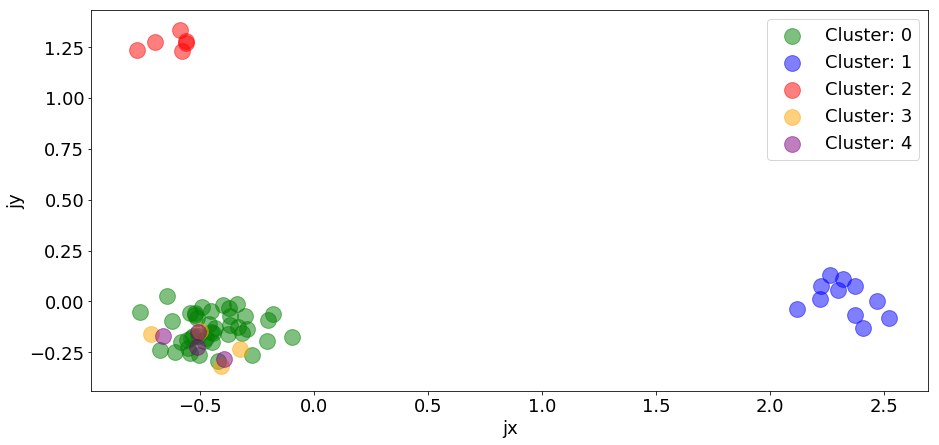

In [45]:
# Jitter so we can see instances that are projected coincident in 2D
bro_df['jx'] = jitter(bro_df['x'])
bro_df['jy'] = jitter(bro_df['y'])

# Now use dataframe group by cluster
cluster_groups = bro_df.groupby('cluster')

# Plot the Machine Learning results
fig, ax = plt.subplots()
colors = {0:'green', 1:'blue', 2:'red', 3:'orange', 4:'purple'}
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])

<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/eyeball.jpeg" width="200px"></div>

## Lets Investigate the 5 clusters of DNS data
**We cramed a bunch of features into the clustering algorithm. The features were both numerical and categorical. So did the clustering 'do the right thing'? Well first some caveats and disclaimers:** 
- We're obviously working with a small amount of Bro DNS data
- This is an example to show how the tranformations work (from Bro to Pandas to Scikit)
- The DNS data is real data but for this example and others we obviously pulled in 'weird' stuff on purpose
- We knew that the K in KMeans should be 5 :)

**Okay will all those caveats lets look at how the clustering did on both numeric and categorical data combined**
### Cluster details
- Cluster 0: (42 observations) Looks like 'normal' DNS requests
- Cluster 1: (11 observations) All the queries are '-' (Bro for NA/not found/etc)
- Cluster 2: ( 6 observations) The protocol is TCP instead of the normal UDP
- Cluster 3: ( 4 observations) The reserved Z bit is set to 1 (required to be 0)
- Cluster 4: ( 4 observations) All the DNS queries are exceptionally long

## Numerical + Categorical = AOK
With our example data we've successfully gone from Bro logs to Pandas to scikit-learn. The clusters appear to make sense and certainly from an investigative and threat hunting perspective being able to cluster the data and use PCA for dimensionality reduction might come in handy depending on your use case 

In [46]:
# Now print out the details for each cluster
pd.set_option('display.width', 1000)
show_fields = ['query', 'Z', 'proto', 'qtype_name', 'cluster']
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[show_fields].head())


Cluster 0: 42 observations
                           query  Z proto qtype_name  cluster
0                     guyspy.com  0   udp          A        0
1                 www.guyspy.com  0   udp          A        0
2   devrubn8mli40.cloudfront.net  0   udp          A        0
3  d31qbv1cthcecs.cloudfront.net  0   udp          A        0
4                crl.entrust.net  0   udp          A        0

Cluster 1: 11 observations
   query  Z proto qtype_name  cluster
39     -  0   udp          -        1
40     -  0   udp          -        1
41     -  0   udp          -        1
42     -  0   udp          -        1
43     -  0   udp          -        1

Cluster 2: 6 observations
            query  Z proto qtype_name  cluster
61  j.maxmind.com  0   tcp          A        2
62  j.maxmind.com  0   tcp          A        2
63  j.maxmind.com  0   tcp          A        2
64  j.maxmind.com  0   tcp          A        2
65  j.maxmind.com  0   tcp          A        2

Cluster 3: 4 observations
        

<div style="float: right; margin: 50px 0px 0px 0px"><img src="https://www.kitware.com/img/small_logo_over.png"></div>
## Wrap Up
Well that's it for this notebook, we'll have an upcoming notebook that addresses some of the issues that we overlooked in this simple example. We use Isolation Forest for anomaly detection which works well for high dimensional data. The notebook will cover both training and streaming evalution against the model.

If you liked this notebook please visit the [BroThon](https://github.com/Kitware/BroThon) project for more notebooks and examples.